In [2]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Step 1: Preprocessing
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

# Step 2: Tensor conversion
def create_dataloaders(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long),
        torch.tensor(y_test, dtype=torch.long),
    )

# Step 3: MLP Definition
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, num_classes=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# Step 4: Training
# def train_mlp_model(X_train, y_train, input_dim, num_classes, epochs=30, lr=0.001):
#     model = CowHealthMLP(input_dim=input_dim, num_classes=num_classes)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     for epoch in range(epochs):
#         model.train()
#         optimizer.zero_grad()
#         output = model(X_train)
#         loss = criterion(output, y_train)
#         loss.backward()
#         optimizer.step()
#         if (epoch + 1) % 5 == 0:
#             print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")
#     return model
import matplotlib.pyplot as plt

def train_mlp_model(X_train, y_train, input_dim, num_classes, epochs=30, lr=0.001):
    model = CowHealthMLP(input_dim=input_dim, num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        loss_history.append(loss_value)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss_value:.4f}")
    
    return model, loss_history


# def plot_confusion_matrix(y_true, y_pred, label_names):
   
#     cm = confusion_matrix(y_true, y_pred, labels=list(range(len(label_names))))

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.show()
# Step 5: Evaluation

def evaluate_model(model, X_test, y_test, label_names):
    model.eval()
    with torch.no_grad():
        preds = model(X_test).argmax(dim=1)
        print("\n📊 Classification Report:")
        print(classification_report(y_test, preds, target_names=label_names))
        # plot_confusion_matrix(y_test.numpy(), preds.numpy(), label_names)
        cm = confusion_matrix(y_test, preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot with counts and normalized percentages
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=False, cmap='Blues', cbar=True)


        for i in range(cm.shape[0]):
             for j in range(cm.shape[1]):
                 plt.text(j+0.5, i+0.5, f"{cm[i, j]}\n({cm_normalized[i,j]*100:.3f}%)",
                    ha='center', va='center',
                    fontsize=10,
                    color='white' if cm_normalized[i,j] > 0.5 else 'black')

        # Tick labels
        plt.xticks(np.arange(len(label_names)) + 0.5, label_names, rotation=45, ha='right')
        plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0)
        plt.title('Confusion Matrix (Counts and Normalized Percentages by Row)', fontsize=14, weight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        

# Step 6: Full pipeline
# def run_pipeline(df, label_cols, drop_cols=None):
#     print("🔄 Running pipeline...")
#     X, y, scaler = preprocess_dataset(df, label_cols=label_cols, drop_cols=drop_cols)
#     X_train, X_test, y_train, y_test = create_dataloaders(X, y)
#     model = train_mlp_model(X_train, y_train, input_dim=X.shape[1], num_classes=len(label_cols))
#     evaluate_model(model, X_test, y_test, label_names=label_cols)
#     return model, scaler
def run_pipeline(df, label_cols, drop_cols=None):
    print("🔄 Running pipeline...")
    X, y, scaler = preprocess_dataset(df, label_cols=label_cols, drop_cols=drop_cols)
    X_train, X_test, y_train, y_test = create_dataloaders(X, y)
    model, loss_history = train_mlp_model(X_train, y_train, input_dim=X.shape[1], num_classes=len(label_cols))
    evaluate_model(model, X_test, y_test, label_names=label_cols)
    
    # 🔽 Plotting the loss function
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, scaler


🔄 Running pipeline...
Epoch 5/30 - Loss: 1.6931
Epoch 10/30 - Loss: 1.5749
Epoch 15/30 - Loss: 1.4471
Epoch 20/30 - Loss: 1.3001
Epoch 25/30 - Loss: 1.1327
Epoch 30/30 - Loss: 0.9534

📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.00      0.00      0.00        78
      calving       0.00      0.00      0.00        18
     lameness       0.00      0.00      0.00         9
     mastitis       0.00      0.00      0.00        12
other_disease       0.00      0.00      0.00        20
           OK       0.93      1.00      0.97      1960

     accuracy                           0.93      2097
    macro avg       0.16      0.17      0.16      2097
 weighted avg       0.87      0.93      0.90      2097



c:\Users\lamia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


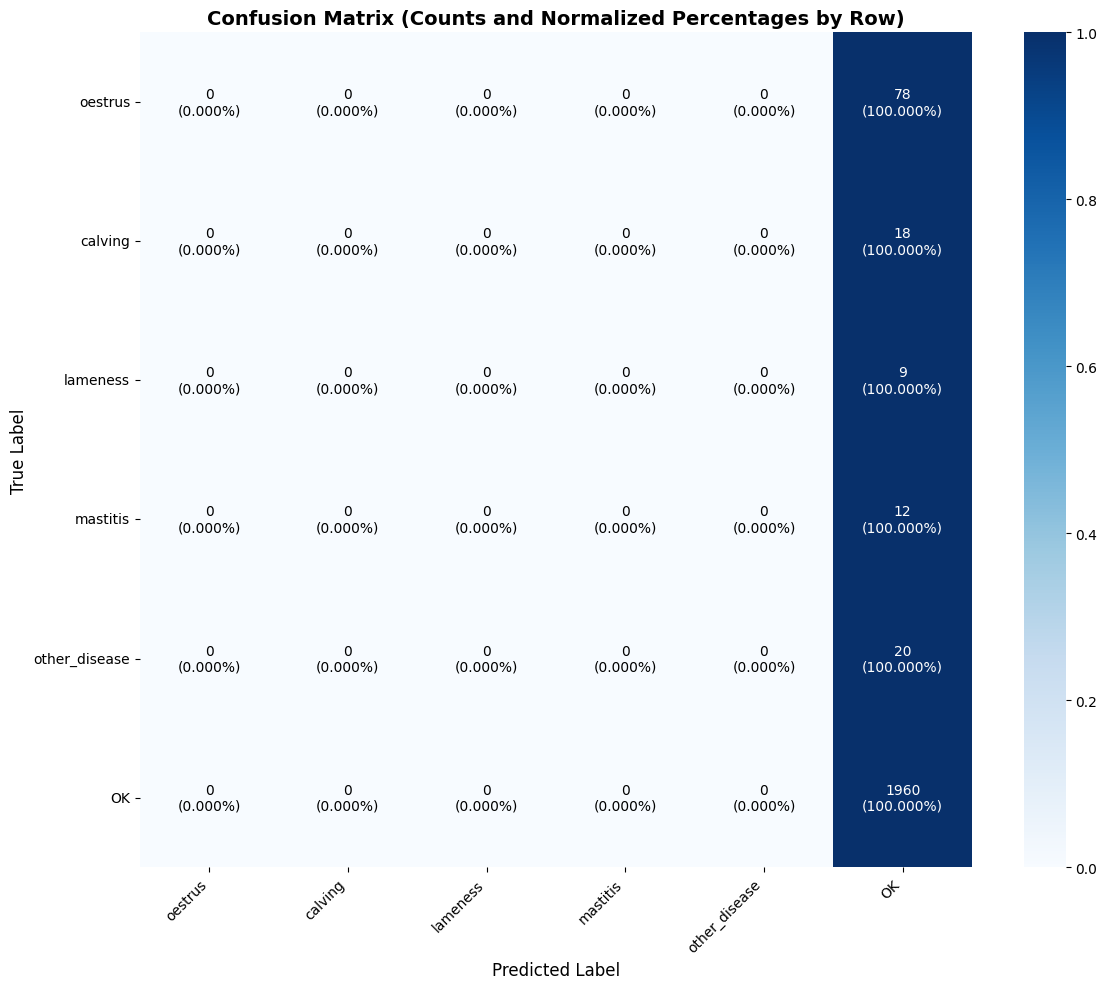

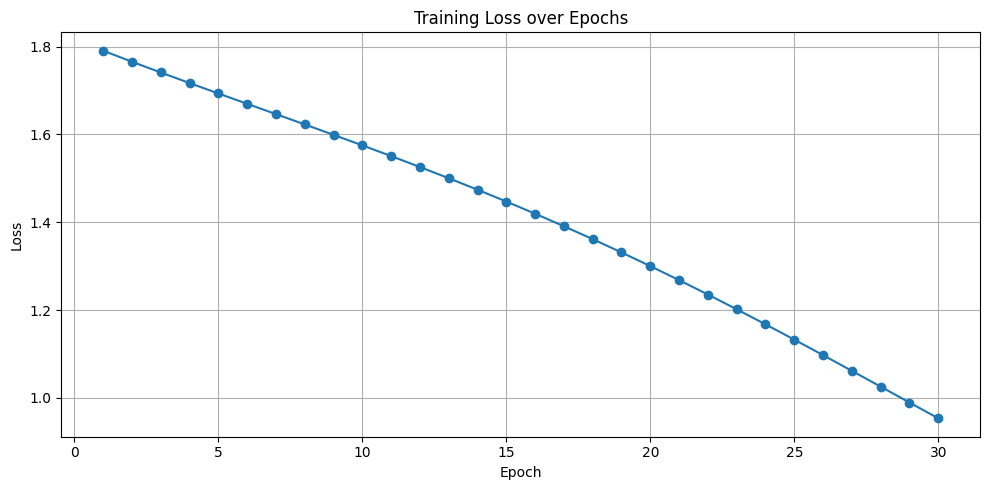

In [3]:
df = pd.read_csv(r"C:/Users/lamia/Downloads/final_selected_dataset1_holdout.csv")
label_columns = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
drop_columns = ['cow', 'start_time', 'end_time']

model, scaler = run_pipeline(df, label_cols=label_columns, drop_cols=drop_columns)


**Improvements (fine tuning)**

In [4]:
    import torch
    import torch.nn as nn
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix, f1_score
    from sklearn.utils.class_weight import compute_class_weight
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import torch
    import torch.nn as nn
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns


    # Preprocessing
    def preprocess_dataset(df, label_cols, drop_cols=None):
        df = df.copy()
        y = df[label_cols].values.argmax(axis=1)
        if drop_cols is None:
            drop_cols = []
        X = df.drop(columns=label_cols + drop_cols)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return X_scaled, y, scaler

    # Class weights for imbalance
    def compute_class_weights(y, num_classes):
        weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=y)
        return torch.tensor(weights, dtype=torch.float32)

    # Train-test split and tensor conversion
    def create_dataloaders(X, y, test_size=0.2, random_state=42):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        return (
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long),
            torch.tensor(y_test, dtype=torch.long),
        )

    # Improved MLP model
    class CowHealthMLP(nn.Module):
        def __init__(self, input_dim, hidden1=128, hidden2=64, num_classes=6):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden1),
                nn.BatchNorm1d(hidden1),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(hidden1, hidden2),
                nn.BatchNorm1d(hidden2),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(hidden2, num_classes)
            )

        def forward(self, x):
            return self.model(x)

    # Model training
    def train_mlp_model(X_train, y_train, input_dim, num_classes, epochs=30, lr=0.001):
        model = CowHealthMLP(input_dim=input_dim, num_classes=num_classes)

        # Compute class weights (assumes you have this function already)
        class_weights = compute_class_weights(y_train.numpy(), num_classes)
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_history = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            optimizer.step()

            loss_value = loss.item()
            loss_history.append(loss_value)

            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {loss_value:.4f}")

        # 📈 Plotting the loss curve
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, epochs + 1), loss_history, marker='o', color='darkorange')
        plt.title("Training Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return model, loss_history


    # Evaluation
    def evaluate_model(model, X_test, y_test, label_names):
        model.eval()
        with torch.no_grad():
            preds = model(X_test).argmax(dim=1)
            print("\n📊 Classification Report:")
            print(classification_report(y_test, preds, target_names=label_names))
            # plot_confusion_matrix(y_test.numpy(), preds.numpy(), label_names)
            cm = confusion_matrix(y_test, preds)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            # Plot with counts and normalized percentages
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm_normalized, annot=False, cmap='Blues', cbar=True)


            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j+0.5, i+0.5, f"{cm[i, j]}\n({cm_normalized[i,j]*100:.3f}%)",
                        ha='center', va='center',
                        fontsize=10,
                        color='white' if cm_normalized[i,j] > 0.5 else 'black')

            # Tick labels
            plt.xticks(np.arange(len(label_names)) + 0.5, label_names, rotation=45, ha='right')
            plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0)
            plt.title('Confusion Matrix (Counts and Normalized Percentages by Row)', fontsize=14, weight='bold')
            plt.xlabel('Predicted Label', fontsize=12)
            plt.ylabel('True Label', fontsize=12)
            plt.tight_layout()
            plt.show()

    # Full pipeline function
    def run_pipeline(df, label_cols, drop_cols=None):
        print("🔄 Running pipeline...")
        X, y, scaler = preprocess_dataset(df, label_cols=label_cols, drop_cols=drop_cols)
        X_train, X_test, y_train, y_test = create_dataloaders(X, y)
        model, loss_history = train_mlp_model(X_train, y_train, input_dim=X.shape[1], num_classes=len(label_cols))
        evaluate_model(model, X_test, y_test, label_names=label_cols)
        
        # # 🔽 Plotting the loss function
        # plt.figure(figsize=(10, 5))
        # plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
        # plt.title('Training Loss over Epochs')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.grid(True)
        # plt.tight_layout()
        # plt.show()

        return model, scaler

🔄 Running pipeline...
Epoch 5/30 - Loss: 1.7319
Epoch 10/30 - Loss: 1.6250
Epoch 15/30 - Loss: 1.5416
Epoch 20/30 - Loss: 1.5136
Epoch 25/30 - Loss: 1.4812
Epoch 30/30 - Loss: 1.3964


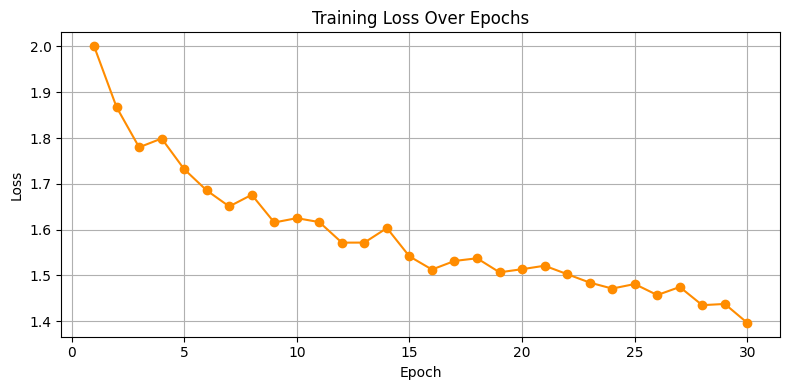


📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.05      0.35      0.08        78
      calving       0.03      0.67      0.06        18
     lameness       0.01      0.44      0.02         9
     mastitis       0.03      0.58      0.05        12
other_disease       0.03      0.30      0.05        20
           OK       0.96      0.12      0.21      1960

     accuracy                           0.14      2097
    macro avg       0.18      0.41      0.08      2097
 weighted avg       0.90      0.14      0.20      2097



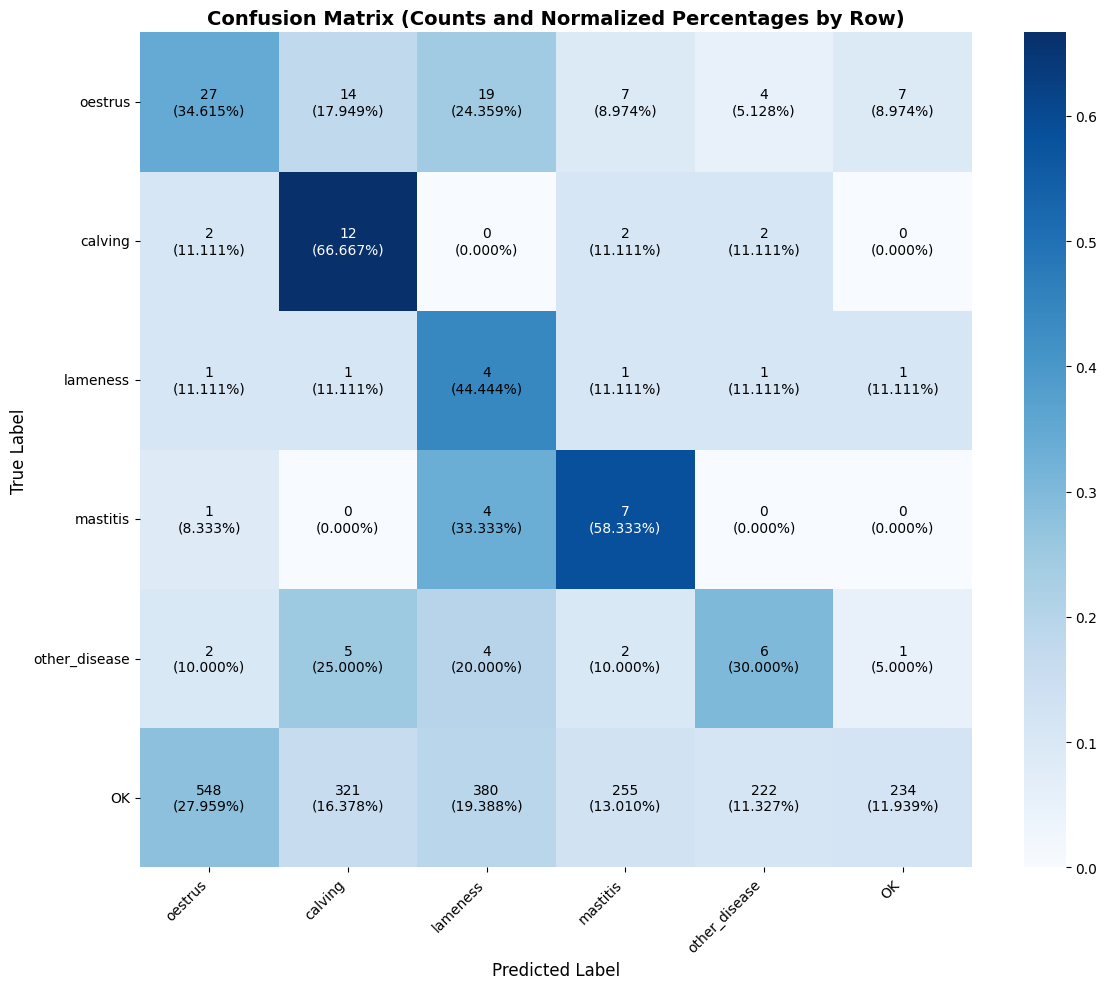

In [5]:
df = pd.read_csv(r"C:/Users/lamia/Downloads/final_selected_dataset1_holdout.csv")
label_columns = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
drop_columns = ['cow', 'start_time', 'end_time']  

model, scaler = run_pipeline(df, label_cols=label_columns, drop_cols=drop_columns)


**More improvements**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, scaler

# Class weights calculation
def compute_class_weights(y, num_classes, method='balanced'):
    if method == 'balanced':
        weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=y)
    elif method == 'inverse':
        class_counts = np.bincount(y)
        weights = 1. / (class_counts + 1e-5)
    else:
        weights = np.ones(num_classes)
    
    return torch.tensor(weights, dtype=torch.float32)

# Dataloaders with validation split
def create_dataloaders(X, y, test_size=0.2, val_size=0.1, batch_size=64, random_state=42):
    # First split into train+val and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Then split train+val into train and val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(1-test_size), 
        random_state=random_state, stratify=y_train_val
    )
    
    # Convert to PyTorch tensors
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    )
    val_dataset = TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.long)
    )
    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

# Configurable MLP model
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], num_classes=6, 
                 dropout_rates=[0.4, 0.3, 0.2], activation='relu', use_batchnorm=True):
        super().__init__()
        layers = []
        
        # Create hidden layers
        prev_dim = input_dim
        for i, (h_dim, dropout) in enumerate(zip(hidden_dims, dropout_rates)):
            layers.append(nn.Linear(prev_dim, h_dim))
            
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h_dim))
                
            # Activation function
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU(0.1))
            elif activation == 'gelu':
                layers.append(nn.GELU())
                
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
            
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

# Training function with hyperparameters
def train_mlp_model(train_loader, val_loader, input_dim, num_classes, 
                   hidden_dims=[256, 128, 64],
                   dropout_rates=[0.4, 0.3, 0.2],
                   activation='relu',
                   use_batchnorm=True,
                   epochs=100, 
                   lr=0.001,
                   weight_decay=1e-4,
                   patience=10,
                   min_delta=0.001):
    
    # Initialize model with specified architecture
    model = CowHealthMLP(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        num_classes=num_classes,
        dropout_rates=dropout_rates,
        activation=activation,
        use_batchnorm=use_batchnorm
    )
    
    # Compute class weights
    all_train_labels = []
    for _, labels in train_loader:
        all_train_labels.extend(labels.numpy())
    class_weights = compute_class_weights(np.array(all_train_labels), num_classes, method='balanced')
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    best_val_loss = float('inf')
    best_model = None
    epochs_no_improve = 0
    train_loss_history = []
    val_loss_history = []
    val_f1_history = []
    
    for epoch in tqdm(range(epochs), desc="Training"):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_loss_history.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        
        # Calculate validation F1 score
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_f1_history.append(val_f1)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
    
    # Load best model weights
    if best_model is not None:
        model.load_state_dict(best_model)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss', color='darkorange')
    plt.plot(val_loss_history, label='Val Loss', color='navy')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(val_f1_history, label='Val F1', color='green')
    plt.title("Validation F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model, train_loss_history, val_loss_history, val_f1_history

# Evaluation function
def evaluate_model(model, test_loader, label_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Classification report
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=False, cmap='Blues', cbar=True)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j+0.5, i+0.5, f"{cm[i, j]}\n({cm_normalized[i,j]*100:.1f}%)",
                    ha='center', va='center',
                    fontsize=10,
                    color='white' if cm_normalized[i,j] > 0.5 else 'black')
    
    plt.xticks(np.arange(len(label_names)) + 0.5, label_names, rotation=45, ha='right')
    plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0)
    plt.title('Confusion Matrix (Counts and Normalized Percentages)', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'confusion_matrix': cm
    }

# Main pipeline function
def run_pipeline(df, label_cols, drop_cols=None, 
                hidden_dims=[256, 128, 64],
                dropout_rates=[0.4, 0.3, 0.2],
                activation='relu',
                use_batchnorm=True,
                batch_size=64,
                lr=0.001,
                weight_decay=1e-4,
                epochs=100):
    
    print("🔄 Running MLP pipeline with hyperparameter tuning...")
    
    # Preprocessing
    X, y, scaler = preprocess_dataset(df, label_cols=label_cols, drop_cols=drop_cols)
    
    # Create dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(
        X, y, batch_size=batch_size
    )
    
    # Train model with specified hyperparameters
    model, train_loss, val_loss, val_f1 = train_mlp_model(
        train_loader, val_loader, 
        input_dim=X.shape[1], 
        num_classes=len(label_cols),
        hidden_dims=hidden_dims,
        dropout_rates=dropout_rates,
        activation=activation,
        use_batchnorm=use_batchnorm,
        lr=lr,
        weight_decay=weight_decay,
        epochs=epochs
    )
    
    # Evaluate model
    results = evaluate_model(model, test_loader, label_names=label_cols)
    
    return model, scaler, results

🔄 Running MLP pipeline with hyperparameter tuning...


Training:   3%|▎         | 5/150 [01:30<44:39, 18.48s/it]


Epoch 5/150
Train Loss: 1.1716 | Val Loss: 1.1164 | Val F1: 0.3703


Training:   7%|▋         | 10/150 [02:51<38:28, 16.49s/it]


Epoch 10/150
Train Loss: 1.0476 | Val Loss: 0.9820 | Val F1: 0.4189


Training:  10%|█         | 15/150 [04:14<37:56, 16.86s/it]


Epoch 15/150
Train Loss: 0.9508 | Val Loss: 0.9116 | Val F1: 0.4732


Training:  13%|█▎        | 20/150 [05:35<35:03, 16.18s/it]


Epoch 20/150
Train Loss: 0.9179 | Val Loss: 0.8230 | Val F1: 0.4671


Training:  17%|█▋        | 25/150 [06:55<32:46, 15.73s/it]


Epoch 25/150
Train Loss: 0.8421 | Val Loss: 0.7864 | Val F1: 0.4691


Training:  20%|██        | 30/150 [08:10<29:58, 14.99s/it]


Epoch 30/150
Train Loss: 0.8108 | Val Loss: 0.7532 | Val F1: 0.5231


Training:  23%|██▎       | 35/150 [09:27<29:29, 15.39s/it]


Epoch 35/150
Train Loss: 0.7588 | Val Loss: 0.7148 | Val F1: 0.5256


Training:  27%|██▋       | 40/150 [3:43:29<40:37:21, 1329.47s/it] 


Epoch 40/150
Train Loss: 0.7531 | Val Loss: 0.7225 | Val F1: 0.4735


Training:  30%|███       | 45/150 [3:44:56<6:55:54, 237.67s/it]  


Epoch 45/150
Train Loss: 0.7163 | Val Loss: 0.6714 | Val F1: 0.5077


Training:  33%|███▎      | 50/150 [3:46:10<1:27:15, 52.35s/it] 


Epoch 50/150
Train Loss: 0.6931 | Val Loss: 0.6464 | Val F1: 0.5028


Training:  37%|███▋      | 55/150 [3:47:26<33:33, 21.20s/it]  


Epoch 55/150
Train Loss: 0.6785 | Val Loss: 0.6083 | Val F1: 0.5428


Training:  40%|████      | 60/150 [3:48:35<22:46, 15.19s/it]


Epoch 60/150
Train Loss: 0.6664 | Val Loss: 0.5927 | Val F1: 0.5175


Training:  43%|████▎     | 65/150 [3:49:44<20:05, 14.18s/it]


Epoch 65/150
Train Loss: 0.6476 | Val Loss: 0.5980 | Val F1: 0.5721


Training:  47%|████▋     | 70/150 [3:50:56<19:06, 14.33s/it]


Epoch 70/150
Train Loss: 0.6292 | Val Loss: 0.5672 | Val F1: 0.6066


Training:  50%|█████     | 75/150 [3:52:04<17:00, 13.61s/it]


Epoch 75/150
Train Loss: 0.6261 | Val Loss: 0.5895 | Val F1: 0.6097


Training:  53%|█████▎    | 80/150 [4:13:49<2:01:55, 104.51s/it]


Epoch 80/150
Train Loss: 0.5493 | Val Loss: 0.5567 | Val F1: 0.5917


Training:  57%|█████▋    | 85/150 [4:14:59<31:33, 29.14s/it]   


Epoch 85/150
Train Loss: 0.5351 | Val Loss: 0.5317 | Val F1: 0.5841


Training:  60%|██████    | 90/150 [4:16:07<16:30, 16.51s/it]


Epoch 90/150
Train Loss: 0.5566 | Val Loss: 0.5192 | Val F1: 0.5936


Training:  63%|██████▎   | 95/150 [4:17:18<13:28, 14.70s/it]


Epoch 95/150
Train Loss: 0.5341 | Val Loss: 0.4990 | Val F1: 0.5952


Training:  67%|██████▋   | 100/150 [4:21:52<29:15, 35.10s/it] 


Epoch 100/150
Train Loss: 0.5457 | Val Loss: 0.5314 | Val F1: 0.5544


Training:  70%|███████   | 105/150 [4:23:04<13:04, 17.43s/it]


Epoch 105/150
Train Loss: 0.5254 | Val Loss: 0.4979 | Val F1: 0.6074


Training:  73%|███████▎  | 110/150 [4:24:03<08:12, 12.31s/it]


Epoch 110/150
Train Loss: 0.5211 | Val Loss: 0.5033 | Val F1: 0.5888


Training:  77%|███████▋  | 115/150 [4:24:59<06:32, 11.22s/it]


Epoch 115/150
Train Loss: 0.5066 | Val Loss: 0.4905 | Val F1: 0.6092


Training:  80%|████████  | 120/150 [4:25:56<05:37, 11.26s/it]


Epoch 120/150
Train Loss: 0.5113 | Val Loss: 0.4829 | Val F1: 0.6086


Training:  83%|████████▎ | 125/150 [4:26:54<05:00, 12.01s/it]


Epoch 125/150
Train Loss: 0.4953 | Val Loss: 0.4816 | Val F1: 0.6117


Training:  87%|████████▋ | 130/150 [4:27:48<03:51, 11.58s/it]


Epoch 130/150
Train Loss: 0.4831 | Val Loss: 0.4860 | Val F1: 0.6031


Training:  90%|█████████ | 135/150 [14:01:02<12:21:03, 2964.22s/it]


Epoch 135/150
Train Loss: 0.4960 | Val Loss: 0.4761 | Val F1: 0.6186


Training:  93%|█████████▎| 140/150 [14:01:38<1:24:02, 504.22s/it]  


Epoch 140/150
Train Loss: 0.5057 | Val Loss: 0.4737 | Val F1: 0.6184


Training:  95%|█████████▌| 143/150 [14:02:14<41:13, 353.39s/it]  


Early stopping at epoch 144


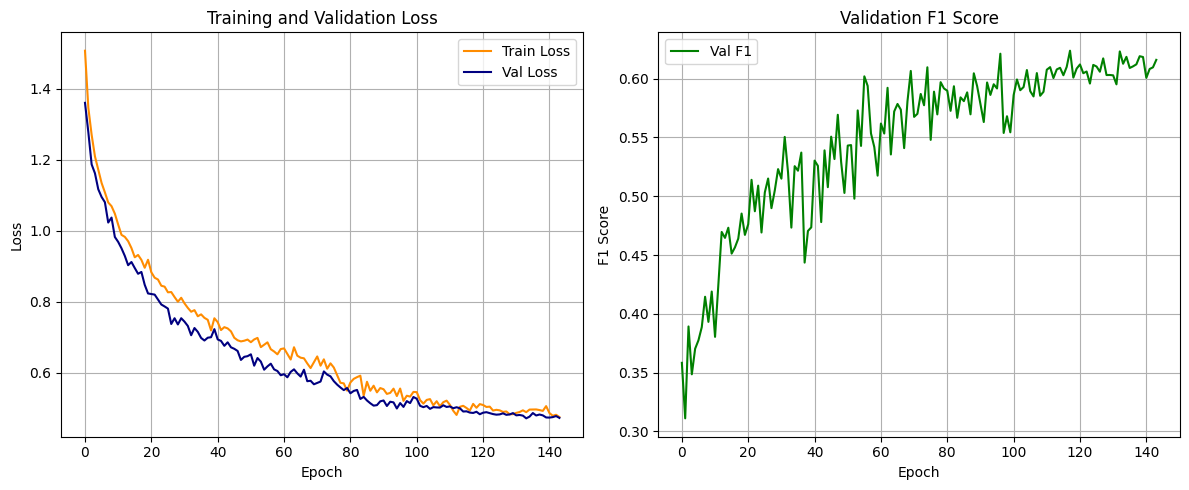


📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.09      0.80      0.17       701
      calving       0.14      0.96      0.24       159
     lameness       0.09      0.96      0.17        85
     mastitis       0.11      0.91      0.19       107
other_disease       0.11      0.95      0.19       180
           OK       0.99      0.48      0.64     17640

     accuracy                           0.50     18872
    macro avg       0.25      0.84      0.27     18872
 weighted avg       0.93      0.50      0.61     18872



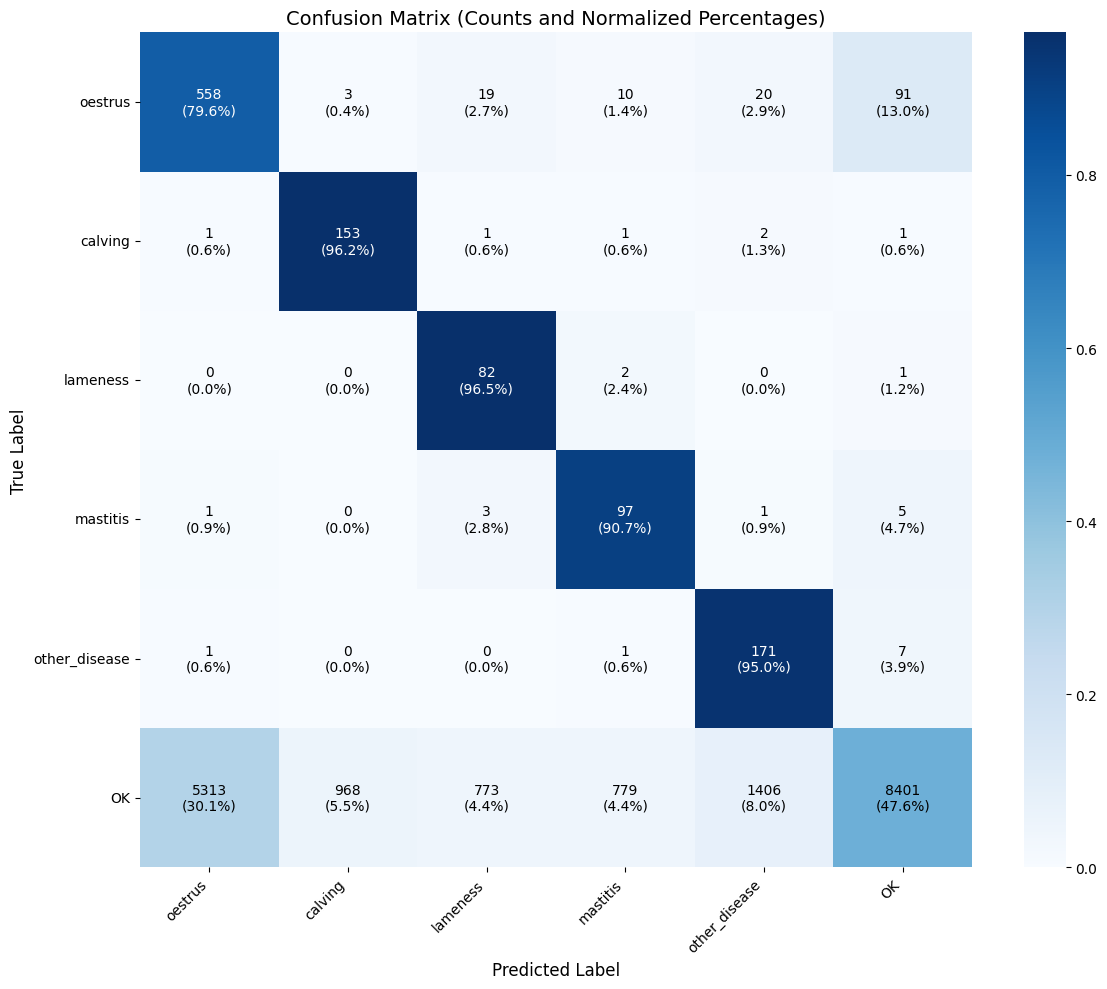

In [9]:
# Example with tuned hyperparameters
model, scaler, results = run_pipeline(
    df = pd.read_csv(r"C:/Users/lamia/Downloads/final_selected_dataset1_trainval.csv"),
    label_cols = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
    drop_cols = ['cow', 'start_time', 'end_time'],
    hidden_dims=[512, 256, 128],  # Deeper network
    dropout_rates=[0.5, 0.4, 0.3],  # Higher dropout
    activation='leakyrelu',  # Different activation
    use_batchnorm=True,
    batch_size=128,
    lr=0.0005,
    weight_decay=1e-4,
    epochs=150
)